In [1]:
from ClosedLoopHelper2ROI import ReadImageStream, get_brain_mask, Position, generate_seeds, GetConfigValues
import ClosedLoopHelper2ROI as clh
import numpy as np
import os
from get_list_data import \
    expt1_data_list
from tqdm import tqdm
import pandas as pd
import re
import json
import pandas as pd
import numpy as np
import os
from os.path import dirname, realpath
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
from configparser import ConfigParser
import numpy as np
import tensortools as tt
import roi_manager
import seaborn as sns
sns.set(font_scale=0.7)
sns.set_style("ticks")
import ClosedLoopHelper2ROI as clh
from get_list_data import \
    expt1_data_list
from IPython.core.debugger import set_trace
from pytictoc import TicToc
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy import stats,signal,fft
from scipy.stats import f_oneway
from scipy.signal import butter, lfilter, filtfilt
import scipy.io as sio
import tables
from statannot import add_stat_annotation
import pymannkendall as mk
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from statannotations.Annotator import Annotator
from pathlib import Path
from numpy import sin, linspace, pi
# from pylab import plot, show, title, xlabel, ylabel, subplot
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing as pp
from numba import jit
from joblib import Parallel, delayed
from sty import fg, bg, ef, rs
from skimage.util import montage
import pickle
import itertools
import matplotlib
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import multiprocessing
import imageio
from skimage.transform import downscale_local_mean

import helper as hlp
import preprocessing as preproc
import hmm_analysis

In [2]:
tmr = TicToc()

data_list = expt1_data_list
data_dir = r"Z:\TM_Lab\Parnian\trdays1-21\example"
processing_root = r"Z:\TM_Lab\Parnian\trdays1-21\example"
plotting_root = r"Z:\TM_Lab\Parnian\trdays1-21\example\plots"


df_perf_all = pd.DataFrame()
seed_auc_arr_all = []
auc_arr_all = []
mice_list = [e[0] for e in data_list]
# groups = [e[4] for e in data_list]
cal_days = list(itertools.chain.from_iterable([e[1] for e in data_list]))

dff_res_all = []

In [3]:
""" FUNCTION """
def corr2_coeff(A, B):
    """
    Row-wise Pearson correlation between rows of A and rows of B.
    A: (n_vars_A, T), B: (n_vars_B, T)
    returns: (n_vars_A, n_vars_B)
    """
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    ssA = (A_mA ** 2).sum(1)
    ssB = (B_mB ** 2).sum(1)

    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))


def seedcorr(se):
    # seed–pixel correlation map from raw dff_filt (no GSR)
    ap0 = int(seeds[se]['AP'] - roi_size[0] / 2)
    ap1 = int(seeds[se]['AP'] + roi_size[0] / 2)
    ml0 = int(seeds[se]['ML'] - roi_size[1] / 2)  # <- width on ML
    ml1 = int(seeds[se]['ML'] + roi_size[1] / 2)

    avgDffSeed = dff_filt[:, ap0:ap1, ml0:ml1].mean(axis=(1, 2))  # (T,)
    # flatten movie to (pixels, T)
    # dff_filt1 = dff_filt.reshape(dff_filt.shape[0], dff_filt.shape[1] * dff_filt.shape[2])
    seedCorr = corr2_coeff(dff_filt1.T, avgDffSeed[np.newaxis, :]).ravel()
    return seedCorr

In [4]:
def spatial_bin_movie(movie, k):
    """
    movie: ndarray with shape (T, H, W) or (T, H, W, C)
    k: integer binning factor (2, 3, 4, ...)
    """
    movie = movie.astype(np.float32, copy=False)
    if movie.ndim == 3:       # (T, H, W)
        return downscale_local_mean(movie, (1, k, k)).astype(np.float32)
    elif movie.ndim == 4:     # (T, H, W, C)
        return downscale_local_mean(movie, (1, k, k, 1)).astype(np.float32)
    else:
        raise ValueError("movie must be (T,H,W) or (T,H,W,C)")


In [5]:
""" MAKE SESS_DF, TRIALS_DF, AND SAVE AS CSV AND PKL """
sess_df = pd.DataFrame(columns=['mouse_id', 'cal_day', 'day', 'sex', 'roi_type', 'roi_rule', 'trials', 'rewards', 'auc', 'target_var'])
sess_df = pd.DataFrame({'mouse_id': pd.Series(dtype='str'),
                            'cal_day': pd.Series(dtype='str'),
                            'day': pd.Series(dtype='int'),
                            'sex': pd.Series(dtype='str'),
                            'roi_type': pd.Series(dtype='str'),
                            'roi_rule': pd.Series(dtype='str'),
                            'trials': pd.Series(dtype='int'),
                            'rewards': pd.Series(dtype='int'),
                            'auc': pd.Series(dtype='float'),
                            'target_var': float})

trials_df = pd.DataFrame(columns=['mouse_id', 'cal_day', 'day', 'sex', 'roi_type', 'roi_rule', 'trial', 'start_ix',
                                'end_ix', 'tr_duration', 'reward'])

sess_df_csv = plotting_root + os.sep + 'clnf_sessions_df' + '.csv'
trials_df_csv = plotting_root + os.sep + 'clnf_trials_df' + '.csv'

dff_res_all_pkl = plotting_root + os.sep + 'clnf_avg_dff_response_all' + '.pkl'
df_perf_all_pkl = plotting_root + os.sep + 'clnf_df_perf_all' + '.pkl'

if os.path.isfile(sess_df_csv):
    sess_df = pd.read_csv(sess_df_csv, dtype = {'mouse_id':str, 'cal_day':str, 'day':int, 'sex':str, 'roi_type':str,
                                                            'roi_rule':str, 'trials':int, 'rewards':int, 'auc':float,
                                                            'target_var':float, 'performance':float})

if os.path.isfile(trials_df_csv):
    trials_df = pd.read_csv(trials_df_csv, dtype = {'mouse_id':str, 'cal_day':str, 'day':int, 'sex':str,
                                                        'roi_type':str, 'roi_rule':str, 'trial':int, 'start_ix':int,
                                                        'end_ix':int, 'tr_duration':float, 'reward': int})

In [6]:
list_day_rec = [[5, '20250520161240'],]
    # [6, '20250521150951'],
    # [7, '20250522152304'],
    # [10, '20250526132638'],
    # [11, '20250527120518'],
    # [13, '20250529152657']]

example_mouse = data_list[1]
mouse_id, sex, _, roi_type = example_mouse
list_rec_dir = [lst_rec_dir for day, lst_rec_dir in list_day_rec]
mouse_dir = data_dir + os.sep + mouse_id + os.sep
processing_mouse_dir = processing_root + os.sep + mouse_id + os.sep
plotting_mouse_dir = plotting_root + os.sep + mouse_id + os.sep


""" SOME VARIABLES """
target_rule_list = []
rois_list = []

avg_reward_dff_timebinned_daily = []

df_perf_mouse = pd.DataFrame()



seedcorrmap_stack = []
seedcorrmap_max = []

""" MAKE DIRECTORIES """
hlp.createdir(plotting_mouse_dir)

In [7]:
for day, rec_dir in tqdm(list_day_rec):
    print('Processing ' + mouse_id + ' ' + ' dir ' + rec_dir + ' day ' + str(day))
    sess_dir = data_dir + os.sep + mouse_id + os.sep + rec_dir + os.sep + 'S1'
    processing_session_dir = processing_mouse_dir + os.sep + rec_dir + os.sep + "S1" + os.sep
    plotting_session_dir = plotting_mouse_dir + os.sep + rec_dir + os.sep + "S1" + os.sep
    hlp.createdir(plotting_session_dir)

    image_path = processing_session_dir + os.sep + 'image_stream.hdf5'
    image_hdf5_file = tables.open_file(image_path, mode='r')
    images = image_hdf5_file.root.raw_images[1000:3000,:,:,:]
    

  0%|          | 0/1 [00:00<?, ?it/s]

Processing 506554m3  dir 20250520161240 day 5


100%|██████████| 1/1 [00:29<00:00, 29.40s/it]


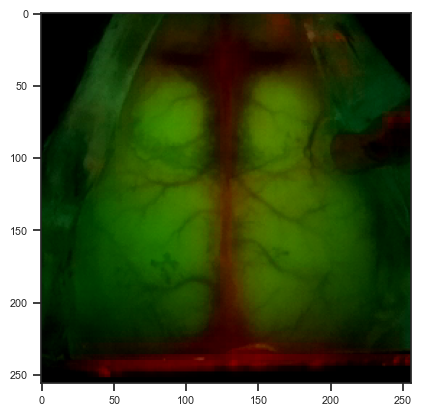

In [8]:
plt.imshow(images[0,:,:,:])

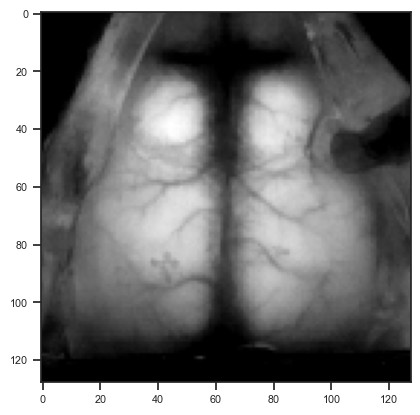

In [9]:
    binned_images = spatial_bin_movie(images, 2)
    plt.imshow(binned_images[0,:,:,1], cmap='gray')


In [11]:
    T, H, W, C = binned_images.shape
    # --- output (final corrected+filtered+masked) ---
    filters = tables.Filters(complevel=5, complib='zlib', shuffle=True)  # keep zlib for portability
    out_path = processing_session_dir + os.sep + 'raw_binned_images.hdf5'
    h5out = tables.open_file(out_path, mode='w')
    OUT = h5out.create_carray('/', 'raw_images', tables.Float32Atom(),
                            shape=(T, H, W, C),
                            obj=binned_images,
                            filters=filters)
    h5out.close()
    OUT.close()

In [12]:


    """ READ CONFIG.INI FILE AND ADD SOME VARIABLES """
    """ READ VIDEOTIMESTAMP.TXT FILE AND ADD SOME VARIABLES, CHANGE THE DATAFRAME """
    data_file = 'VideoTimestamp.txt'
    df_perf = pd.read_csv(sess_dir + os.sep + data_file, sep='\t', parse_dates=['time'])

    """ GET CONFIG VALUES """
    cfgDict = clh.GetConfigValues(sess_dir)
    # tr_st, tr_en = clh.get_trials_ix(sess_dir)
    ppmm = float(cfgDict['ppmm'])
    bregma = list(map(int, cfgDict['bregma'].split(', ')))
    # bregma = [108, 128]
    ppmm = ppmm/2
    bregma = [bregma[0]/2, bregma[1]/2]

In [13]:
    # roi_size in config file is in mm. We convert it to pixel coordinates and round off.
    roi_size = [int(round(x)) for x in np.array([float(i) for i in cfgDict['roi_size'].split(',')]) * ppmm]

    cfgDict['seeds_mm'] = json.loads(cfgDict['seeds_mm'])
    # seeds_mm = cfgDict['seeds_mm']
    # total_trials = int(cfgDict['total_trials'])

    br = clh.Position(bregma[0], bregma[1])
    seeds = clh.generate_seeds(br, cfgDict['seeds_mm'] , ppmm, 'u')
        
    # # one green frame for drawing
    # frames = ReadImageStream(os.path.join(sess_dir, 'image_stream.hdf5'), ix=[100])
    # image  = frames[0, :, :, 1]  # green channel

    # make seed markers (optional but useful)
    # br = Position(bregma[0], bregma[1])
    # seeds = generate_seeds(br, seeds_mm, ppmm, 'u')
    rois = []
    other_rois = []
    if roi_type == '2ROI':
        roi_names = re.split('[-+/%]',cfgDict['roi_operation'])
        roi_op = re.split('([-+/%])',cfgDict['roi_operation'])
        roi_op_str = roi_op[0] + 'dff' + roi_op[1] + roi_op[2] + 'dff'
        roi_name = cfgDict['roi_operation']
        dffCol = roi_op[0] + 'dff' + roi_op[1] + roi_op[2] + 'dff'
        roi1 = roi_names[0]
        roi2 = roi_names[1]
        if 'roi_names' in cfgDict: #exp4 2ROI
            # dffCol      = 'roi1dff-roi2dff'
            for name in roi_names:
                rec = list(map(int, cfgDict[name].split(',')))
                rois.append(roi_manager.Rect(name,
                                            x=rec[0], y= rec[1],w= rec[2],h=rec[3],
                                            color=list(map(int, cfgDict[name+'color'].split(',')))))
        else: #other 2ROI exp
            for name in roi_names:
                seed = seeds[name]
                rois.append(roi_manager.Rect(name,
                                            x= int(seed['ML']-roi_size[0]/2),
                                            y= int(seed['AP']-roi_size[1]/2),
                                            w= roi_size[0],h=roi_size[1],
                                            color=[0,0,255]))

    for name in seeds:
        seed = seeds[name]
        other_rois.append(roi_manager.Rect(name,
                                            x= int(seed['ML']-roi_size[0]/2),
                                            y= int(seed['AP']-roi_size[1]/2),
                                            w= roi_size[0],h=roi_size[1],
                                            color=[0,0,255]))
    df_perf['time'] = [a.timestamp() - df_perf.time[0].timestamp() for a in df_perf.time]
    df_perf['mouse_id'] = mouse_id
    df_perf['sex'] = sex
    df_perf['roi_type'] = roi_type
    # df['day'] = day;
    df_perf['rec_dir'] = rec_dir
    df_perf['rule'] = roi_name
    if roi_type == '1ROI':
        df_perf['roi1dff'] = df_perf[roi_name + 'dff']
        df_perf['roi2dff'] = np.nan
    elif roi_type == '2ROI':
        df_perf['roi1dff'] = df_perf[roi_names[0] + 'dff']
        df_perf['roi2dff'] = df_perf[roi_names[1] + 'dff']
        
    # df.rename(columns={dffCol: 'target_dff'}, inplace=True)
    if 'trial' not in df_perf: df_perf['trial'] = 0
    if 'lick' not in df_perf: df_perf['lick'] = 0




    tr_st, tr_en = clh.get_trials_ix(sess_dir)

    roi_name = cfgDict['roi_operation']
    # target_rule_list.append(roi_name)
    # rois_list.append(rois)
    brain_fps = int(cfgDict['framerate'])
    total_trials = int(cfgDict['total_trials'])

    epochSize = int(3 * brain_fps)
    trials_ix = df_perf[df_perf.trial > 0].index
    rests_ix = df_perf[df_perf.trial == 0].index
    starts_ix = np.where(np.diff(df_perf.trial.values) > 0)[0]
    ends_ix = np.where(np.diff(df_perf.trial.values) < 0)[0]
    rew_df = df_perf[df_perf.reward == 1]

    reward_ix = df_perf[df_perf.reward == 1].index
    reward_ix = reward_ix[1:][np.diff(reward_ix) > 2 * epochSize] # make sure indices are far enough from each other
    for ix in reward_ix: # make sure, each epoch is indexing within the range
        epoch = np.arange(ix - epochSize, ix + epochSize)
        if not (np.prod(epoch >= 0) and np.prod(epoch < len(df_perf))):
            reward_ix = np.delete(reward_ix, np.where(reward_ix == ix))
            continue

    fail_ix = df_perf[df_perf.reward == -1].index
    n_rewards = len(df_perf[df_perf['reward'] ==1])



    target_rule_list.append(roi_name)
    rois_list.append(rois)


    df_perf['success_rate'] = (n_rewards / total_trials) if total_trials else np.nan
    df_perf['total_trials'] = int(total_trials)
    df_perf['rewards'] = int(n_rewards)

    df_perf.rename(columns={dffCol: 'target_dff'}, inplace=True)
    
    df_perf_mouse = pd.concat([df_perf_mouse, df_perf], ignore_index=True)

    df_perf.rename(columns={'target_dff':dffCol}, inplace=True)


In [14]:

    """ PLOT AVERAGE TARGET DFF ACTIVITY AROUND REWARD HERE (WITH ERROR BARS) """
    print(fg.red+'Average DFF Around Reward'+fg.rs)
    hlp.plt_avg_dff_reward (df_perf, reward_ix, epochSize, dffCol, brain_fps, rec_dir, mouse_id, day, plotting_mouse_dir)

Average DFF Around Reward


In [15]:
%matplotlib qt

In [16]:

    """ LOAD MASKS AND EXAMPLE IMAGES """
    mask_path = processing_mouse_dir + os.sep + mouse_id + "_mask.png"
    image_path = processing_session_dir + os.sep + 'raw_binned_images.hdf5'
    dorsal_map_path = processing_mouse_dir + os.sep + mouse_id + '_dorsalMap.mat'
    # open
    image = clh.ReadImageStream(image_path, ix=[1000])
    mask = clh.get_brain_mask(mask_path, binned_images[0, :, :, 1], seeds)
    print("Saved mask to:", mask_path)
    mask = mask.astype(float)
    mask[mask == 0] = np.nan
    mask = np.nan_to_num(mask)


Saved mask to: Z:\TM_Lab\Parnian\trdays1-21\example\506554m3\\506554m3_mask.png


In [17]:
%matplotlib inline

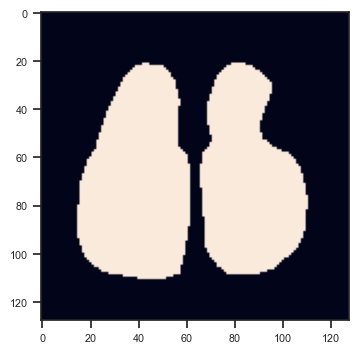

In [18]:
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(mask)

In [19]:
    dorsal_map_path = processing_mouse_dir + os.sep + mouse_id + '_dorsalMap.mat'

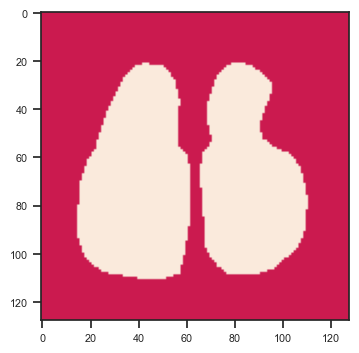

In [20]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(mask, vmin=-0.1, vmax=0.1)

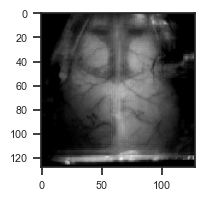

In [ ]:
    # blue image
    fig = plt.figure(figsize=(2, 2))
    blue_img = binned_images[0, :, :, 0]
    plt.imshow(blue_img, cmap='gray')

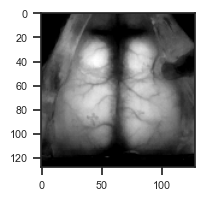

In [ ]:
    # green image
    fig = plt.figure(figsize=(2, 2))
    green_img = binned_images[0, :, :, 1]
    plt.imshow(green_img, cmap='gray')

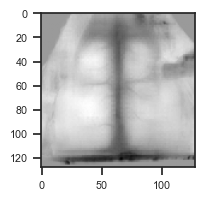

In [ ]:
    # corrected, green - blue image
    fig = plt.figure(figsize=(2, 2))
    corr_img = binned_images[0, :, :, 1] - binned_images[0, :, :, 0]
    plt.imshow(corr_img, cmap='gray')

128 128


c:\Users\pentium\miniforge3\envs\clopy\lib\site-packages\scipy\io\matlab\_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


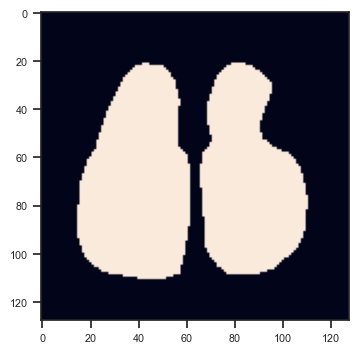

In [24]:
    """ ALLEN DORSAL MAP """
    dorsal_map = sio.loadmat(dorsal_map_path)
    [h, w] = dorsal_map['brainmask'].shape
    print(h, w)
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(dorsal_map['brainmask'])

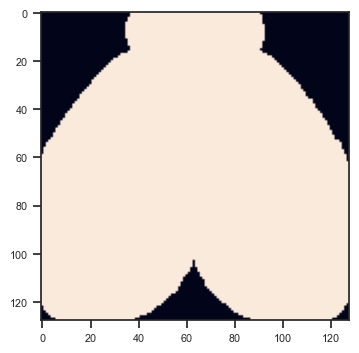

In [25]:
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(dorsal_map['dorsalMapMask'])

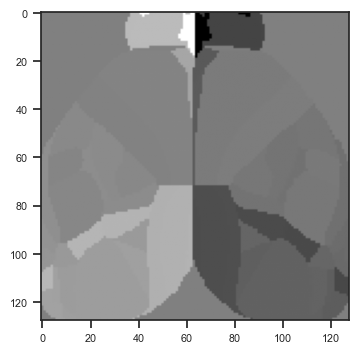

In [26]:
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(dorsal_map['dorsalMapLR'], cmap='gray')

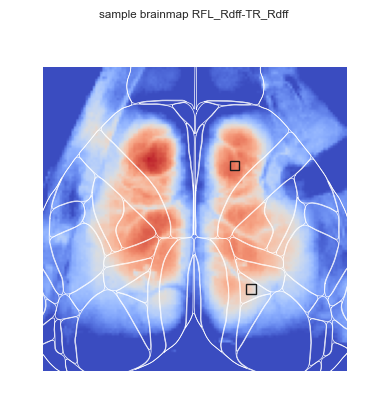

In [ ]:

    """ CHECK BRAINMAP ALIGNMENT WITH ROI LOCATIONS (SEEDPIXEL BASED) """
    fig, ax = plt.subplots(1, 1)
    ret = ax.imshow(np.squeeze(binned_images[1000,:, :, 1]), vmin=20, vmax=150, cmap='coolwarm')
    plt.grid(False)
    [ax.plot(r[0][:, 0] - 1, r[0][:, 1] - 1, 'w', linewidth=0.5) for r in dorsal_map['edgeOutlineRegionsLR']]  # -1 because this is exported from matlab where indexing starts at 1
    for roi in rois:
        rect1 = patches.Rectangle(
            (int(roi.x), int(roi.y)),
            roi.w, roi.h, linewidth=1, edgecolor='k', facecolor='none')
        ax.add_patch(rect1)

    ax.axis('off')
    plt.title('sample brainmap' + ' ' + dffCol)
    fig.savefig(plotting_mouse_dir + os.sep + 'brainmap_alignment.png')



In [32]:
binned_images.shape

(2000, 128, 128, 3)

In [33]:
mask.shape

(128, 128)

**NO CORRECTION**

In [ ]:

    """ LOAD MASKS AND EXAMPLE IMAGES """
    mask_path = processing_mouse_dir + os.sep + mouse_id + "_mask.png"
    image_path = processing_session_dir + os.sep + 'raw_binned_images.hdf5'
    dorsal_map_path = processing_mouse_dir + os.sep + mouse_id + '_dorsalMap.mat'
    # open
    image = clh.ReadImageStream(image_path, ix=[1000])
    mask = clh.get_brain_mask(mask_path, binned_images[0, :, :, 1], seeds)
    print("Saved mask to:", mask_path)

    mask = mask.astype(float)
    mask[mask == 0] = np.nan
    mask = np.nan_to_num(mask)


Saved mask to: Z:\TM_Lab\Parnian\trdays1-21\example\506554m3\\506554m3_mask.png


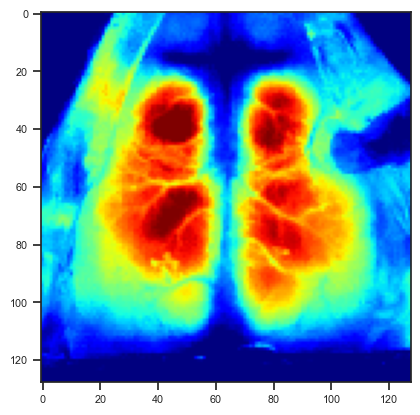

In [251]:
plt.imshow(binned_images[1000,:, :, 1], vmin=np.percentile(binned_images[1000,:, :, 1], 1), vmax=np.percentile(binned_images[1000,:, :, 1], 99), cmap='jet', rasterized=True)

In [252]:

    """ APPLY MASK """
    print(fg.red+'Applying Mask'+fg.rs)
    masked_images_g = mask * binned_images[...,1]
    tmr.toc()

Applying Mask
Elapsed time is nan seconds.


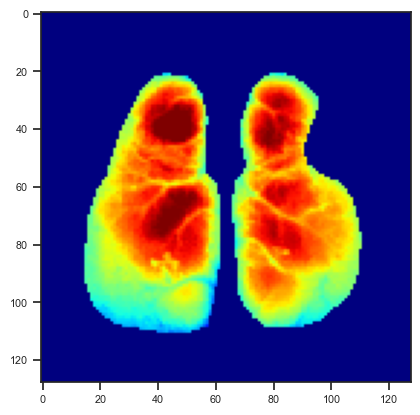

In [254]:
plt.imshow(masked_images_g[1000,:, :], vmin=np.percentile(masked_images_g[1000,:, :], 1), vmax=np.percentile(masked_images_g[1000,:, :], 99), cmap='jet', rasterized=True)

In [97]:
    T, H, W = masked_images_g.shape
    masked_images_g = masked_images_g.astype(np.float32)
    # --- output (final corrected+filtered+masked) ---
    filters = tables.Filters(complevel=5, complib='zlib', shuffle=True)  # keep zlib for portability
    out_path = processing_session_dir + os.sep + 'masked_images_g.hdf5'
    h5out = tables.open_file(out_path, mode='w')
    OUT = h5out.create_carray('/', 'raw_images', tables.Float32Atom(),
                            shape=(T, H, W),
                            obj=masked_images_g,
                            filters=filters)
    h5out.close()
    OUT.close()

In [96]:

masked_image_path = processing_session_dir + os.sep + 'masked_images_g.hdf5'

In [ ]:

    """ NO CORRECTION """
    if os.path.exists(processing_session_dir + os.sep + 'dff_preproc_no_correction.hdf5'):
        print(fg.red+'Loading brain data: '+fg.rs, processing_session_dir)
        image_hdf5_file = tables.open_file(processing_session_dir + os.sep + 'dff_preproc_no_correction.hdf5', mode='r')
        dff_filt_ = image_hdf5_file.root.dff_preproc_no_correction[:, :, :]
        image_hdf5_file.close()
        tmr.toc()
    else:
        print(fg.red+'Analyzing brain data: '+fg.rs, processing_session_dir)
        dff_filt_, baseline_ = hlp.analyzebrain_no_correction (masked_image_path, processing_session_dir)
        tmr.toc()

Loading brain data:  Z:\TM_Lab\Parnian\trdays1-21\example\506554m3\\20250520161240\S1\
Elapsed time is nan seconds.


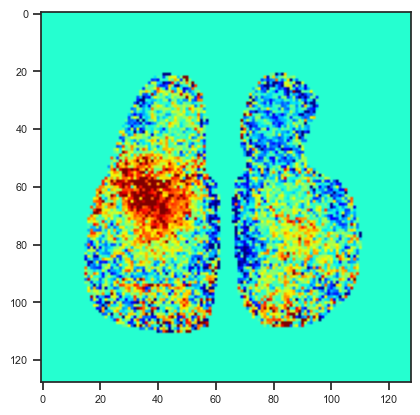

In [266]:
    plt.imshow(dff_filt_[1000,:, :], vmin=np.percentile(dff_filt_[1000,:, :], 1), vmax=np.percentile(dff_filt_[1000,:, :], 99), cmap='jet')

In [46]:
    print(dff_filt_.shape)

(2000, 128, 128)


In [269]:
    """ TEMPORAL LOWPASS FILTERING """
    print(fg.red+'Applying temporal lowpass filters'+fg.rs)
    dff_filt_ = preproc.temporal_filter(dff_filt_, fs=brain_fps)
    tmr.toc()

Applying temporal lowpass filters
Elapsed time is nan seconds.


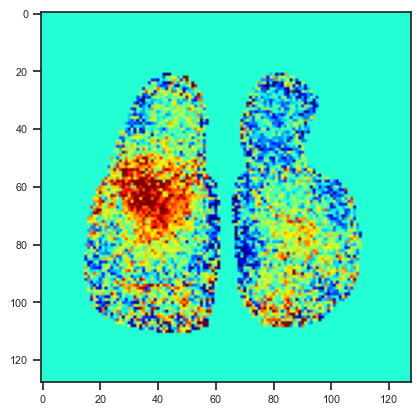

In [271]:
    plt.imshow(dff_filt_[1000,:, :], vmin=np.percentile(dff_filt_[1000,:, :], 1), vmax=np.percentile(dff_filt_[1000,:, :], 99), cmap='jet')

In [272]:

    """ APPLY SPATIAL GAUSSIAN FILTER """
    print(fg.red+'Filtering DFF'+fg.rs)
    # dff_filt = OUT.copy()
    # del OUT
    dff_filt_ = gaussian_filter(dff_filt_, sigma=(0,0.5,0.5))
    tmr.toc()

Filtering DFF
Elapsed time is nan seconds.


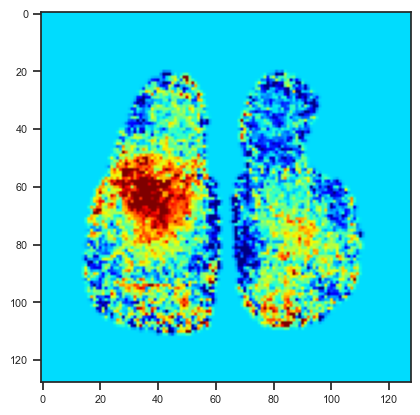

In [273]:
    plt.imshow(dff_filt_[1000,:, :], vmin=np.percentile(dff_filt_[1000,:, :], 1), vmax=np.percentile(dff_filt_[1000,:, :], 99), cmap='jet')

**PCA**

In [106]:
pca_model_, xz_, scores_ = hlp.fit_pca_image(dff_filt_)

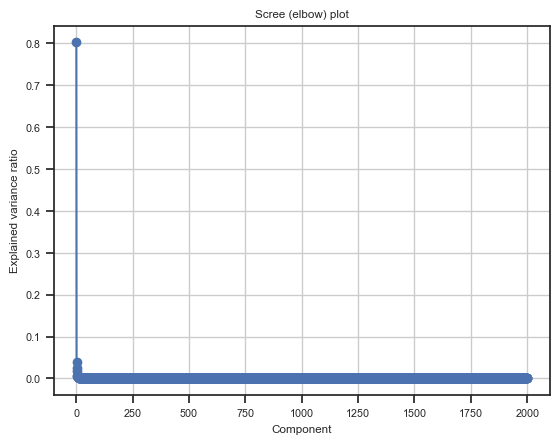

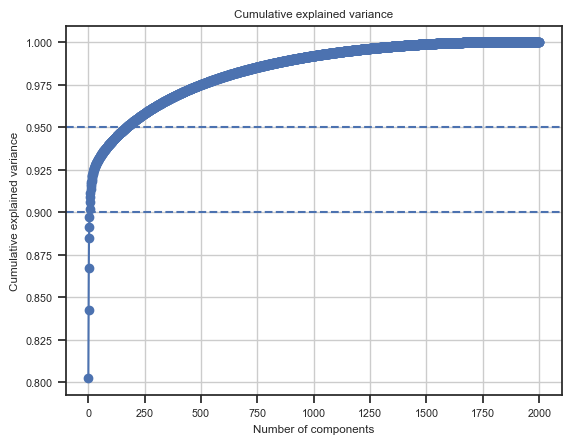

Components for ≥90% variance: 7 | for ≥95%: 170


In [107]:
hlp.plot_elbow(pca_model_)

In [108]:
T_, H_, W_ = dff_filt_.shape

In [237]:
def spatial_map(pca, comp_idx, H, W):
    comp = pca.components_[comp_idx].reshape(H, W)

    plt.figure()
    
    plt.imshow(comp, vmin=np.percentile(comp, 1), vmax=np.percentile(comp, 99), cmap='jet')
    plt.colorbar()
    plt.title(f"PCA component #{comp_idx} (spatial map)")
    plt.axis("off")
    plt.show()

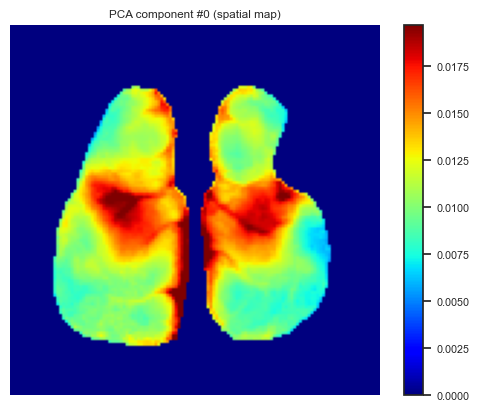

In [238]:
spatial_map(pca_model_, 0, H_, W_)


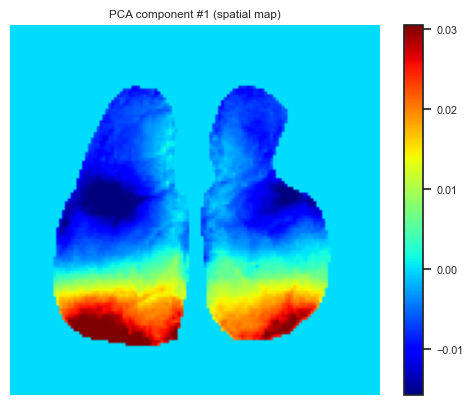

In [239]:
spatial_map(pca_model_, 1, H_, W_)


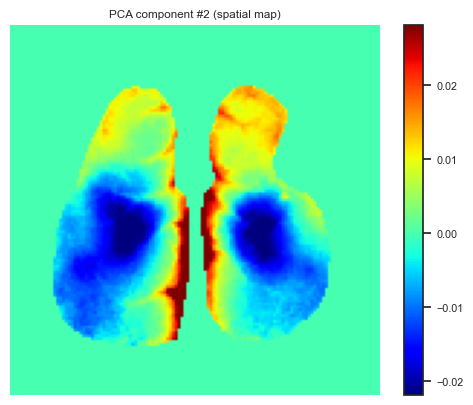

In [240]:
spatial_map(pca_model_, 2, H_, W_)


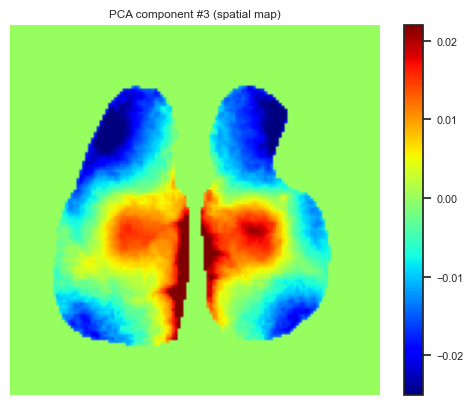

In [241]:
spatial_map(pca_model_, 3, H_, W_)


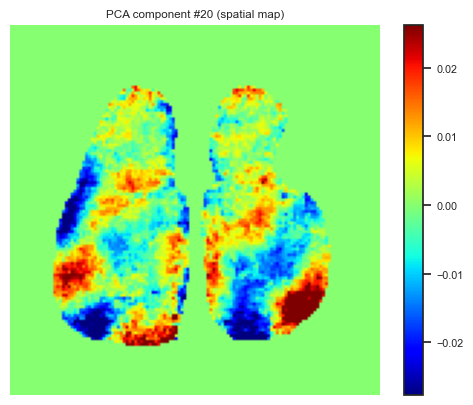

In [242]:
spatial_map(pca_model_, 20, H_, W_)


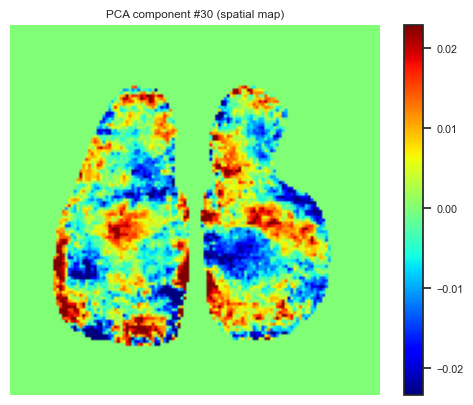

In [243]:
spatial_map(pca_model_, 30, H_, W_)


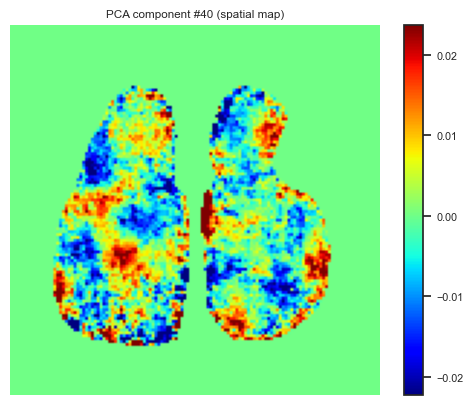

In [244]:
spatial_map(pca_model_, 40, H_, W_)


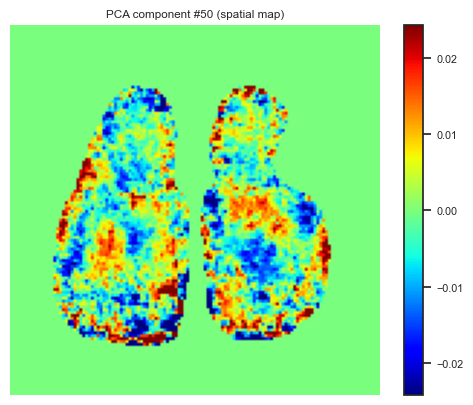

In [245]:
spatial_map(pca_model_, 50, H_, W_)


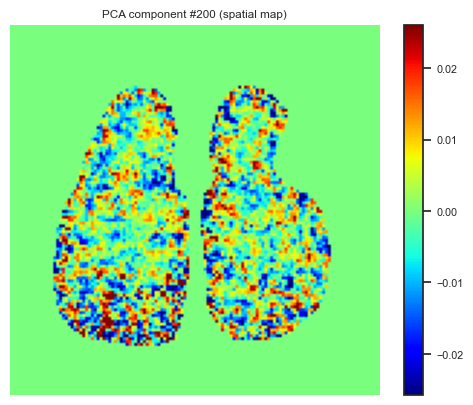

In [246]:
spatial_map(pca_model_, 200, H_, W_)


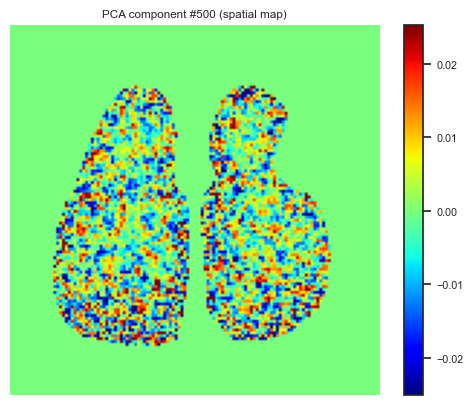

In [247]:
spatial_map(pca_model_, 500, H_, W_)


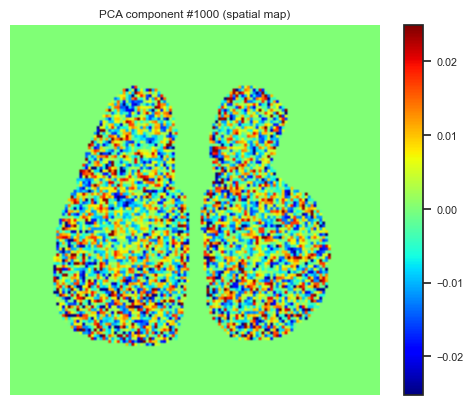

In [248]:
spatial_map(pca_model_, 1000, H_, W_)


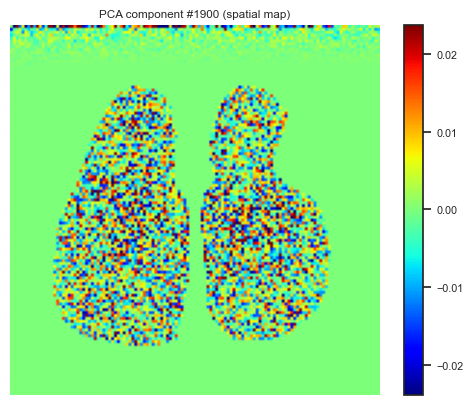

In [249]:
spatial_map(pca_model_, 1900, H_, W_)


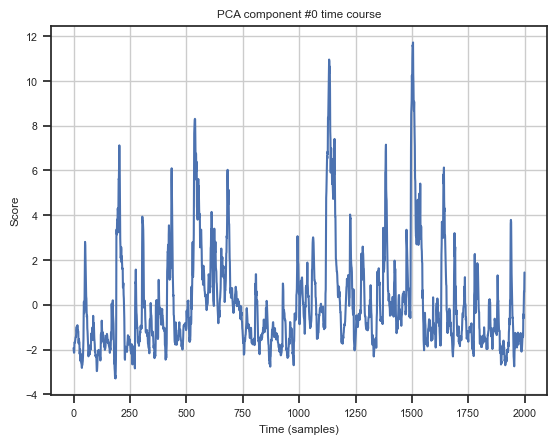

In [151]:
hlp.plot_timecourse(pca_model_, 0, scores_)


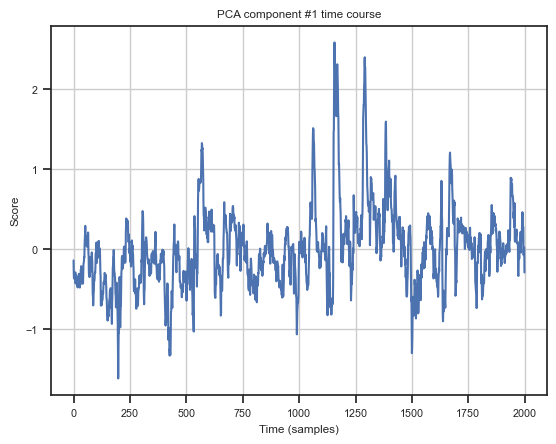

In [152]:
hlp.plot_timecourse(pca_model_, 1, scores_)


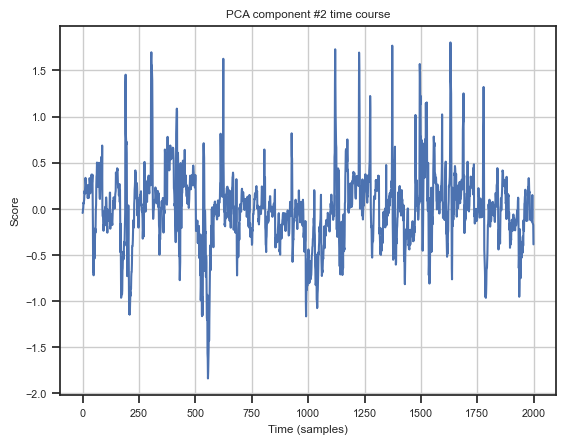

In [153]:

hlp.plot_timecourse(pca_model_, 2, scores_)


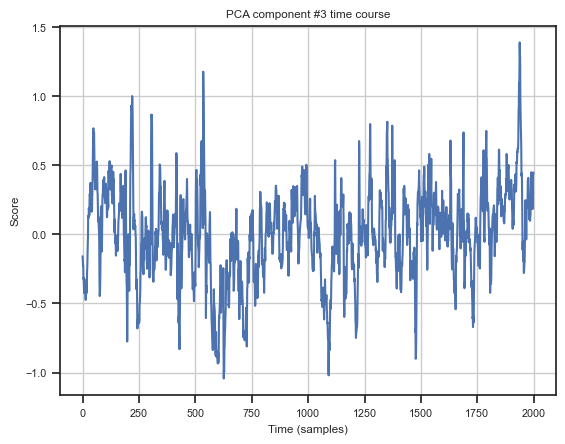

In [154]:

hlp.plot_timecourse(pca_model_, 3, scores_)


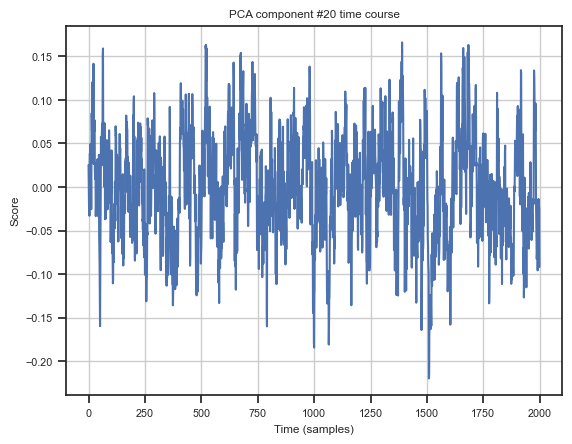

In [155]:

hlp.plot_timecourse(pca_model_, 20, scores_)


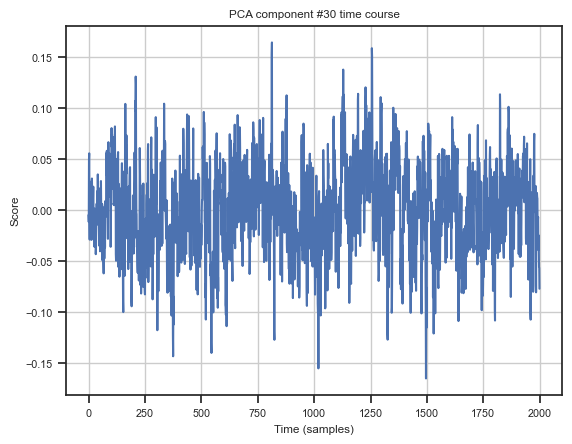

In [156]:
hlp.plot_timecourse(pca_model_, 30, scores_)


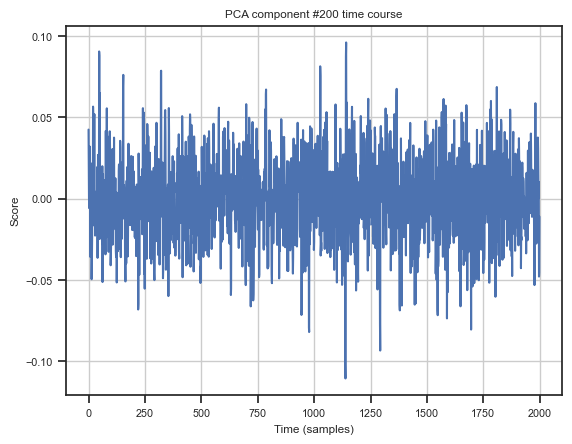

In [157]:

hlp.plot_timecourse(pca_model_, 200, scores_)


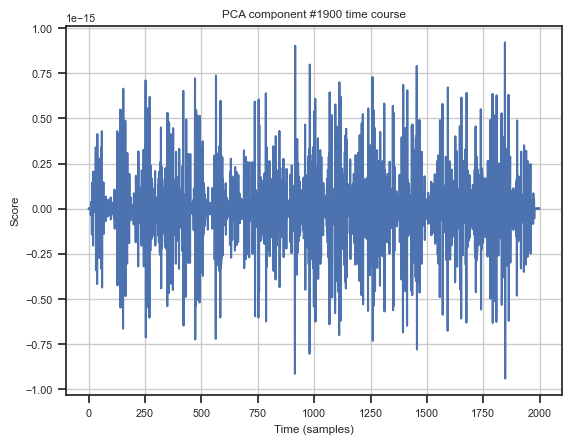

In [158]:

hlp.plot_timecourse(pca_model_, 1900, scores_)


In [161]:
samples_, components_ = scores_.shape
drop_indices_ = [i>40 for i in range(components_)]
reconstructed_ = hlp.reconstruct_image(pca_model_, xz_, drop_indices_)


In [162]:
reconstructed_.shape


(2000, 16384)

In [163]:
reconstructed_ = reconstructed_.reshape(T_, H_, W_)

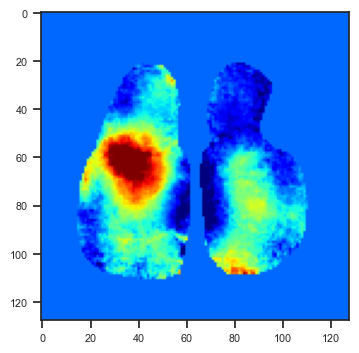

In [276]:
reconstructed_ = reconstructed_ * mask

fig = plt.figure(figsize=(4, 4))
plt.imshow(reconstructed_[1000,:, :], vmin=np.percentile(reconstructed_[1000,:, :], 1), vmax=np.percentile(reconstructed_[1000,:, :], 99), cmap='jet', rasterized=True)
# plt.colorbar()

**PLOTS**

In [ ]:
    """ PLOT AVERAGE REWARD CENTERED GIF BRAIN MAP """
    print(fg.red+'GIF'+fg.rs)
    hlp.plt_gif_map (dff_filt_ , reward_ix, epochSize, plotting_mouse_dir, mouse_id, rec_dir, day, brain_fps, rois, roi_name)

    """ PLOT AVERAGE REWARD CENTERED BRAIN MAP """
    print(fg.red+'Brainmaps'+fg.rs)
    avg_reward_dff_timebinned_daily = hlp.plt_avg_rew_map (dff_filt_, reward_ix, epochSize, plotting_mouse_dir, mouse_id, rec_dir, day, brain_fps, rois, avg_reward_dff_timebinned_daily)


**SEEDPIXEL CORRELATION**

In [ ]:
    # flatten once outside loop (T, H*W)
    dff_filt1 = dff_filt.reshape(dff_filt.shape[0], dff_filt.shape[1] * dff_filt.shape[2])

In [ ]:
    """ CALCULATE SEED PIXEL CORRELATION MAPS"""
    print(fg.red + 'Calculating seedpixel corr maps in loop' + fg.rs)
    seedcorr_results = []
    for ix, se in enumerate(seeds):
        corr_map = seedcorr(se)
        seedcorr_results.append(corr_map)
    seedcorr_results = np.vstack(seedcorr_results)  # (n_seeds, H*W)

    tmr.toc()

In [ ]:
    """ CALCULATE EACH SEED'S DFF TIME SERIES"""
    seed_dff = {}
    for ix, se in enumerate(seeds):
        ap0 = int(seeds[se]['AP'] - roi_size[0] / 2)
        ap1 = int(seeds[se]['AP'] + roi_size[0] / 2)
        ml0 = int(seeds[se]['ML'] - roi_size[1] / 2)
        ml1 = int(seeds[se]['ML'] + roi_size[1] / 2)

        s_dff = dff_filt_[:, ap0:ap1, ml0:ml1].mean(axis=(1, 2))
        seed_dff[se] = s_dff

In [ ]:
    """ SAVE"""
    with open(processing_session_dir + os.sep + 'seed_results.pkl', 'wb') as seed_result_file:
        # keep your existing order/structure as much as possible         # assumes computed elsewhere same as before
        pickle.dump(seedcorr_results, seed_result_file)         # (n_seeds, H*W), raw only
        pickle.dump(seed_dff, seed_result_file)                 # raw only

In [ ]:
    rest_st = 0
    with open(processing_session_dir + os.sep + 'seed_results.pkl', 'rb') as file:
        seedcorr_results = pickle.load(file)
        seed_dff = pickle.load(file)

In [ ]:
    """SEEDPIXEL CORRELATION MAP MONTAGE"""
    H = dff_filt_.shape[1]
    W = dff_filt_.shape[2]
    seedcorr_results = seedcorr_results.reshape(len(seeds), H, W)
    seedcorrmap_stack.append(montage(seedcorr_results))
    seedcorrmap_max.append(np.nanmax(seedcorr_results, axis=0))

In [ ]:
    """ PLOT AVERAGE REWARD CENTERED TRACE IN DIFFERENT SEEDS """
    print(fg.red+'Seeds'+fg.rs)
    dff_res_all = hlp.plt_avg_seed_rew (dff_filt, reward_ix, epochSize, plotting_mouse_dir, mouse_id, rec_dir, day, brain_fps, cfgDict, seeds, dff_res_all, roi_name)


In [ ]:

""" PLOT THE BIG REWARD CENTERED BRAIN MAPS FOR ALL SESSIONS OF A SINGLE MOUSE, AND SAVE THE VARIABLE """
print(fg.red+'Big Reward-Centered Brain Map'+fg.rs)
avg_reward_dff_timebinned_daily = np.stack(avg_reward_dff_timebinned_daily)
avg_reward_dff_timebinned_daily = hlp.plt_avg_rew_map_all (epochSize, plotting_mouse_dir, mouse_id, brain_fps, avg_reward_dff_timebinned_daily)



In [ ]:

""" PLOT SEEDCORRMAP_STACK AND SEEDCORRMAP_MAX AND SAVE THE VARIABLES """
seedcorrmap_stack = np.dstack(seedcorrmap_stack)
seedcorrmap_stack, seedcorrmap_max = hlp.plt_seedcorrmap(seedcorrmap_stack, seedcorrmap_max, target_rule_list, rois_list, roi_size, plotting_mouse_dir, mouse_id, rec_dir, day)


In [ ]:

""" UPDATE DF_PERF_ALL, DATAFRAME CONTAINING DATA OF ALL MICE """
""" PLOT SUCCESS RATE HERE"""
hlp.plt_success (df_perf_mouse, mouse_id, plotting_mouse_dir)
df_perf_all = pd.concat([df_perf_all, df_perf_mouse], ignore_index=True)   